# Social Media Analytics
## Project 3
## Text Mining - Topic Modeling (Reddit Posts)
Felix Funes 20220306 | Paula Catalan 20221048 | Efstathia Styliagkatzi 20220078 | Alisson Tapia 20221156 | S M Abrar Hossain Asif 20220223

In this notebook, our main goal is to gain valuable insights about the iPhone 14 by analyzing a collection of posts from Reddit. By applying various text mining techniques, we aim to uncover hidden patterns and themes within the data, providing us with a deeper understanding of people's experiences and opinions regarding the different models of the iPhone 14.

By performing topic modeling analysis, we can achieve a range of valuable outcomes. Firstly, topic modeling allows us to uncover the underlying themes or topics within the collected documents, revealing patterns and structures without requiring manual reading and categorization of each individual review. This not only saves time but also provides a holistic view of the dataset.

Furthermore, topic modeling helps us enhance our understanding of the text corpus by summarizing and organizing the textual information into meaningful topics. With large amounts of text data, it's easy to feel overwhelmed, but topic modeling simplifies the exploration and comprehension of the dataset, making it more approachable and manageable.

Topic modeling also plays a significant role in market research and customer insights. By applying it to customer reviews, and social media data, we can identify prevalent topics and sentiments. This empowers businesses with valuable information about customer preferences, concerns, and trends. It can guide product development, inform marketing strategies, and contribute to customer satisfaction analysis.

Throughout this notebook, we will leverage the power of topic modeling to gain insights into the iPhone 14 reviews and uncover the key topics that emerge from Reddit posts. By doing so, we hope to shed light on the experiences, opinions, and trends surrounding the iPhone 14 models, contributing to a comprehensive understanding of this popular device.

## Initial Setup

In [1]:
# Import packages
!pip install --user numpy==1.21.2


import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk 
import re
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

import gensim         
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

!pip install pyLDAvis
import spacy

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

!pip install --upgrade pandas numpy scipy pyLDAvis

  Using cached numpy-1.21.2-cp39-cp39-win_amd64.whl (14.0 MB)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
pandas-profiling 3.3.0 requires joblib~=1.1.0, but you have joblib 1.2.0 which is incompatible.
pandas-profiling 3.3.0 requires pandas!=1.4.0,<1.5,>1.1, but you have pandas 2.0.2 which is incompatible.
pandas-profiling 3.3.0 requires scipy<1.10,>=1.4.1, but you have scipy 1.10.1 which is incompatible.
pyldavis 3.4.1 requires numpy>=1.24.2, but you have numpy 1.21.2 which is incompatible.


  Using cached numpy-1.24.3-cp39-cp39-win_amd64.whl (14.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.2
    Uninstalling numpy-1.21.2:
      Successfully uninstalled numpy-1.21.2


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Felix\\AppData\\Roaming\\Python\\Python39\\site-packages\\~.mpy\\.libs\\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



In [2]:
# Just because of versions on my computer
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# Load dataset
dtypes = {'type':'category','subreddit':'category','score':'float64','title':'category','reviews':'category','author':'category'}
ds= pd.read_excel("https://github.com/felix-funes/social-media-analytics/blob/main/iphone-subreddit-comments.xlsx?raw=true", sheet_name="Sheet1", engine='openpyxl', dtype=dtypes)

## Text Preprocessing

In [4]:
# Text preprocessing
def textPreProcess(rawText, removeHTML=True, charsToRemove = r'\?|\.|\!|\;|\.|\"|\,|\(|\)|\&|\:|\-', removeNumbers=True, removeLineBreaks=False, specialCharsToRemove = r'[^\x00-\xfd]', convertToLower=True, removeConsecutiveSpaces=True):
    if type(rawText) != str:
        return rawText
    procText = rawText
        
    # Remove HTML
    if removeHTML:
        procText = BeautifulSoup(procText,'html.parser').get_text()

    # Remove punctuation and other special characters
    if len(charsToRemove)>0:
        procText = re.sub(charsToRemove,' ',procText)

    # Remove numbers
    if removeNumbers:
        procText = re.sub(r'\d+',' ',procText)

    # Remove line breaks
    if removeLineBreaks:
        procText = procText.replace('\n',' ').replace('\r', '')

    # Remove special characters
    if len(specialCharsToRemove)>0:
        procText = re.sub(specialCharsToRemove,' ',procText)

    # Normalize to lower case
    if convertToLower:
        procText = procText.lower() 

    # Replace multiple consecutive spaces with just one space
    if removeConsecutiveSpaces:
        procText = re.sub(' +', ' ', procText)

    return procText

In [5]:
# Tokenize words
def tokenize_words(words):
    if (type(words) != str) or (word_tokenize(words) == ''):
        return np.nan
    else:
        return word_tokenize(words)

In [6]:
# Function to create text from words
def recreateText(words):
    if type(words) == list:
        temp_str = (' ').join(words)
        return temp_str
    else:
        return np.nan

In [7]:
# Function to remove stop words
def removeStopWords(t, stop_words):
    if type(t) == list:
        return [w for w in t if not w in stop_words]
    else:
        return np.nan

In [8]:
# Function to lemmatize words
def lemmatize(words):
    if type(words) == list:
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(x) for x in words]
    else:
        return np.nan

In [9]:
# Create a dataframe with only the description
processedReviews = pd.DataFrame(data=ds.body.apply(textPreProcess).values, index=ds.index, columns=['PreProcessedText'])

c:\Users\Felix\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
c:\Users\Felix\anaconda3\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [10]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Felix\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Felix\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [11]:
# Tokenize words
processedReviews['Words'] =  processedReviews['PreProcessedText'].apply(tokenize_words)

# Remove stopwords
stop_words = set(stopwords.words('english'))
processedReviews['WordsCleaned'] = processedReviews['Words'].apply(removeStopWords,stop_words=stop_words)

# Remove all reviews with no words
processedReviews = processedReviews[processedReviews['WordsCleaned'].str.len()>0]

# Lemmatize words
processedReviews['WordsLemmatized'] = processedReviews['WordsCleaned'].apply(lemmatize)

## Analysis

In [12]:
# Create dictionary (needed for LDA)
id2word = corpora.Dictionary(processedReviews['WordsLemmatized'])

In [13]:
# Create corpus
corpus = processedReviews['WordsLemmatized']

In [14]:
# Create TDM (Frequency)
tdm = [id2word.doc2bow(text) for text in corpus]

In [15]:
# Build LDA model (can take from 2 to 10 minutes depending on the computer)
lda_model = gensim.models.ldamodel.LdaModel(corpus=tdm,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=123,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [16]:
# Print the keywords in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[tdm]
# Interpretation: Topic 0 is represented as 0.055"walking" + 0.054"garden" + ...

[(0, '0.064*"phone" + 0.026*"need" + 0.023*"icloud" + 0.022*"use" + 0.020*"iphone" + 0.018*"want" + 0.014*"get" + 0.014*"apps" + 0.013*"got" + 0.012*"backup"'), (1, '0.040*"carrier" + 0.037*"sim" + 0.036*"esim" + 0.022*"phone" + 0.021*"]" + 0.021*"[" + 0.021*"know" + 0.020*"apple" + 0.015*"support" + 0.014*"take"'), (2, '0.044*"photo" + 0.026*"device" + 0.024*"think" + 0.023*"right" + 0.017*"like" + 0.016*"check" + 0.015*"thank" + 0.014*"video" + 0.014*"make" + 0.013*"show"'), (3, '0.026*"e" + 0.024*"http" + 0.021*"call" + 0.021*"someone" + 0.019*"sound" + 0.019*"%" + 0.019*"every" + 0.018*"fine" + 0.017*"//www" + 0.013*"lol"'), (4, '0.025*"u" + 0.023*"since" + 0.022*"problem" + 0.020*"case" + 0.017*"thanks" + 0.016*"http" + 0.016*"review" + 0.015*"battery" + 0.015*"thing" + 0.013*"good"'), (5, '0.034*"iphone" + 0.031*"new" + 0.026*"phone" + 0.024*"work" + 0.023*"n\'t" + 0.021*"get" + 0.019*"apple" + 0.018*"esim" + 0.016*"one" + 0.014*"would"'), (6, '0.063*"*" + 0.038*"even" + 0.020*"i

In [17]:
# Prepare the data for visualization using pyLDAvis
vis = gensimvis.prepare(lda_model, tdm, id2word)

# Display the visualization
pyLDAvis.display(vis)

### Insights of the graph

The LDA model identifies eight topics (as specified by num_topics=8) and assigns keywords to each topic. The keywords provide an insight into the main themes or areas of discussion in the analyzed dataset. Each topic is represented by a list of words and their corresponding weights.

We can see here that in Topic 1 there are several words that show a higher weight. Some of them are:"work", "esim","app", "time" and "charge". The weight of a keyword indicates the likelihood of that word occurring in the given topic. The higher the weight, the more representative and important the word is for the topic.

In topic 2 we can see that the words that have more weight are: "screen", "button" , "gb", and "use", which complements the previous insights that we got from the other analysis from Best Buy and Reddit.

### Evaluation of topic models

In [18]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(tdm))  # lower value is better (some liteture do not recommend the use of this measure)


Perplexity:  -7.6676216003398885


In [19]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=corpus, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3888959415226483


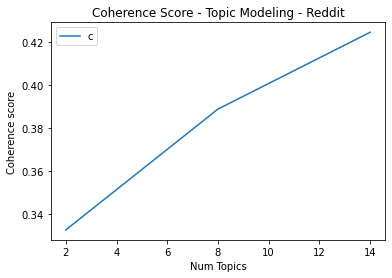

In [20]:
# HOW TO SELECT K (based on https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=123,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# ATTENTION!!!! Can take a LONG time to run.
lowerBound = 2
upperBound = 20
step = 6
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=tdm, texts=corpus, start=lowerBound, limit=upperBound, step= step)

# Show graph
x = range(lowerBound, upperBound, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.title("Coherence Score - Topic Modeling - Reddit")
plt.show()
# The coherence score is decreasing. A higher value should be chosen, because as K increases the probability of having repeated keywords increases.
# ...So, in this case we may choose 8, as there is an inflaction at K=8

## Conclusions

This code snippet computes the perplexity of an LDA (Latent Dirichlet Allocation) model. The perplexity is a measure of how well the model predicts a sample or a set of documents. A lower perplexity value indicates better performance.

Then code calculates the coherence score of an LDA model. Coherence is a measure of the interpretability and consistency of the topics generated by the model. The code creates a CoherenceModel object with the LDA model (lda_model), the corpus, the dictionary, and the coherence measure ('c_v'). The coherence score is obtained using the get_coherence method of the coherence_model_lda object. The code then prints the coherence score.

Finally, the code defines a function called compute_coherence_values that computes the coherence values for different numbers of topics in an LDA model. The function takes in a Gensim dictionary, a Gensim corpus, a list of input texts, a limit on the maximum number of topics to consider, and the start and step values for the range of topics.

A perplexity value of -7.6676216003398885 suggests a very low perplexity, which indicates that the LDA model is performing well in predicting the sample or set of documents. Lower perplexity values generally indicate better model performance. In this case, the negative value may be due to the logarithmic transformation typically applied to perplexity calculations. Therefore, a lower negative value still indicates a good performance.

A coherence score of 0.3888959415226483 indicates a moderate level of coherence and interpretability for the topics generated by the LDA model. Coherence scores typically range between 0 and 1, where higher values indicate better topic quality.

It also suggests that the topics have some level of coherence and are reasonably interpretable. However, there is room for improvement, as a higher coherence score would indicate more distinct and coherent topics.